This notebook demonstrates how to find the convex hulls of two distinct traced dendritic trees,  
and to find the convex hulls that represent the spatial intersection and union of the two hulls.  
The volumes of the resulting meshes are used to calculate the Jaccard similarity coefficient, defined as follows:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7">

Requirements:
- pyimagej
- trimesh (+ Blender backend for boolean operations)
  - see https://github.com/mikedh/trimesh/blob/master/trimesh/interfaces/blender.py for the expected locations of the Blender       executable
- numpy


In [1]:
import os
import imagej
import numpy as np
from trimesh import PointCloud
from trimesh.boolean import intersection
from trimesh.boolean import union

In [2]:
"""Replace with path to your local Fiji installation.
This can be replaced with ij = imagej.init('sc.fiji:fiji')
once the scijava branch is merged to master."""

ij = imagej.init(r'C:\Users\cam\Desktop\Fiji.app', headless=False)

from jnius import autoclass, cast

In [3]:
# Import relevant Java classes.
PointInImage = autoclass('sc.fiji.snt.util.PointInImage')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
Tree = autoclass('sc.fiji.snt.Tree')
MultiTreeColorMapper = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
Color = autoclass('org.scijava.util.Colors')
ColorTables = autoclass("net.imagej.display.ColorTables")
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')

In [4]:
def fetch_reconstruction(id):
    """Return an sc.fiji.snt.Tree object of the given ID string,
    if the ID exists in the MouseLight database."""
    
    # Get loader for specified id.
    loader = MouseLightLoader(id)
    
    if not loader.isDatabaseAvailable():
        print("Could not connect to ML database", "Error")
        return
    
    if not loader.idExists():
        print("Somewhow the specified id was not found", "Error")
        return
    
    # Get sc.fiji.snt.Tree object representing the dendrites,
    # setting color to None.
    tree = loader.getTree('dendrites', None)
    
    return tree

In [5]:
def get_node_coordinates(tree):
    """Return a 2D numpy array of node
    [x,y,z] coordinates for all nodes of the given 
    sc.fiji.snt.Tree"""
    
    # Get nodes as Java collection of PointInImage objects.
    points = tree.getNodes()
    
    # Get x,y,z coordinates from PointInImage objects.
    points_iterator = points.iterator()
    points_list = []
    while points_iterator.hasNext():
        p = points_iterator.next()
        points_list.append([p.x, p.y, p.z])

    return np.asarray(points_list)

In [6]:
def run():
    
    # Two cells from Primary Motor Area, layer 5.
    # Their dendrites exhibit a high degree of spatial overlap.
    neuron_ids = ["AA0133", "AA0134"]
    trees = []
    meshes = []

    for id in neuron_ids:
        # Get dendrite reconstruction from MouseLight database.
        tree = fetch_reconstruction(id)
        if tree is None:
            print("{} not found in database, exiting.".format(id))
            return
        
        tree.setLabel(id)
        trees.append(tree)
        
        # Find the convex hull of the tracing with trimesh.
        tree_points = get_node_coordinates(tree)
        tree_cloud = PointCloud(tree_points)
        tree_hull = tree_cloud.convex_hull
        meshes.append(tree_hull)
    
    # Get spatial intersection of both hulls as 
    # another convex hull.
    intersection_hull = intersection(meshes, engine='blender')
    if len(intersection_hull.vertices) == 0:
        print("No spatial overlap found, exiting.")
        return
    
    # Compute the union hull of both hulls.
    union_hull = union(meshes, engine='blender')
    
    # Calculate the Jaccard similarity.
    print("The Jaccard similarity is {}".format((intersection_hull.volume/union_hull.volume)))
    
    # Make a list of the outer vertices of the intersection hull
    # as PointInImage objects to pass to Viewer3D for rendering.
    verts = intersection_hull.vertices
    verts_list = []
    for v in verts:
        verts_list.append(PointInImage(v[0], v[1], v[2]))
    # Convert to Java collection using pyimagej.
    verts_java = ij.py.to_java(verts_list)
    
    viewer = Viewer3D()
    for t in trees:
        viewer.add(t)
    
    # Tree color in the viewer may be set using the neuron id string.
    colors = ij.py.to_java(neuron_ids)
    viewer.colorCode(colors, MultiTreeColorMapper.ID, ColorTables.ICE)
    # Pass the vertices of the intersection hull to render as a Delaunay surface.
    surface = viewer.annotateSurface(verts_java, "Intersection")
    surface.setColor("cyan")
    
    viewer.show()
    # Let's take a snapshot of the Viewer scene
    snapshot_path = os.getcwd() + '/notebook-snapshots/recViewer-snapshot.png'
    viewer.saveSnapshot(snapshot_path)
    # To embed the snapshot in this notebook, we can call
    from IPython.display import Image, display
    display(Image(filename=snapshot_path))

The Jaccard similarity is 0.5057671897938841


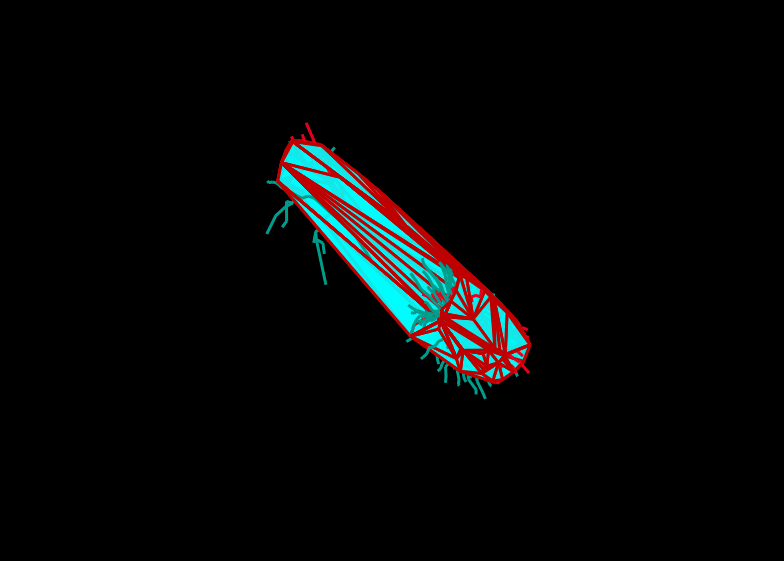

In [7]:
run()